In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# load related dataset
df_ols = pd.read_table('data/orderlines.txt',delimiter='\t',engine='python')
df_ols.head()

,orderlineid,orderid,productid,shipdate,billdate,unitprice,numunits,totalprice
0,1010561,1006414,10834,2011-03-07 00:00:00,2011-03-08 00:00:00,18.00,1,18.00
1,1010562,1006541,11052,2011-01-19 00:00:00,2011-01-20 00:00:00,10.00,2,20.00
2,1010563,1006542,11070,2011-01-19 00:00:00,2011-01-20 00:00:00,19.12,1,19.12
3,1010564,1010154,11196,2009-11-19 00:00:00,2009-11-20 00:00:00,14.95,1,14.95
4,1010565,1009110,11048,2009-11-11 00:00:00,2009-11-12 00:00:00,10.00,2,20.00


In [3]:
df_ols.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286017 entries, 0 to 286016
Data columns (total 8 columns):
orderlineid    286017 non-null int64
orderid        286017 non-null int64
productid      286017 non-null int64
shipdate       286017 non-null object
billdate       286017 non-null object
unitprice      281033 non-null float64
numunits       286017 non-null int64
totalprice     286017 non-null float64
dtypes: float64(2), int64(4), object(2)
memory usage: 17.5+ MB


SQL:
<pre>
SELECT ShipDate, COUNT(*) as numship
FROM OrderLines
GROUP BY ShipDate
ORDER BY ShipDate
</pre>

In [4]:
# Counts the number of order lines shipped on a given each day
# Step1:Convert "string-type date column" to "timestamp type index (DatetimeIndex)"
df_ols['shipdate'] = pd.to_datetime(df_ols['shipdate'])
# df_ols.info()
df_ols_shipIndex = df_ols.set_index(df_ols['shipdate'])
df_ols_shipIndex.head()

# Step2:
res_numship = df_ols_shipIndex['orderlineid'].groupby(level=0).count()
res_numship.head()

shipdate
2009-10-22    85
2009-10-23    68
2009-10-26     5
2009-10-27    14
2009-10-28     1
Name: orderlineid, dtype: int64

SQL:
<pre>
SELECT COALESCE(s.ShipDate, b.BillDate) as thedate,
COALESCE(s.numship, 0) as numship,
COALESCE(b.numbill, 0) as numbill
FROM (SELECT ShipDate, COUNT(*) as numship
FROM OrderLines
GROUP BY ShipDate
) s FULL OUTER JOIN
(SELECT BillDate, COUNT(*) as numbill
FROM OrderLines
GROUP BY BillDate
) b
ON s.ShipDate = b.BillDate
ORDER BY thedate
</pre>

In [5]:
# Count: How many items shipped each day and how many billed each day? 
# Step1:
df_ols['billdate'] = pd.to_datetime(df_ols['billdate'])
df_ols_billIndex = df_ols.set_index(df_ols['billdate'])
df_ols_billIndex.head()

#Step2:
res_numbill = df_ols_billIndex['orderlineid'].groupby(level=0).count()
res_numbill.head()

#Step3:
res_all = pd.merge(pd.DataFrame(res_numship),pd.DataFrame(res_numbill),how='outer',left_index=True,right_index=True)
res_all.rename(columns={'orderlineid_x':'numship','orderlineid_y':'numbill'},inplace=True)
res_all.fillna(0, inplace=True)
res_all.astype(np.int).head()

,numship,numbill
2009-10-22,85,0
2009-10-23,68,85
2009-10-24,0,68
2009-10-26,5,0
2009-10-27,14,5


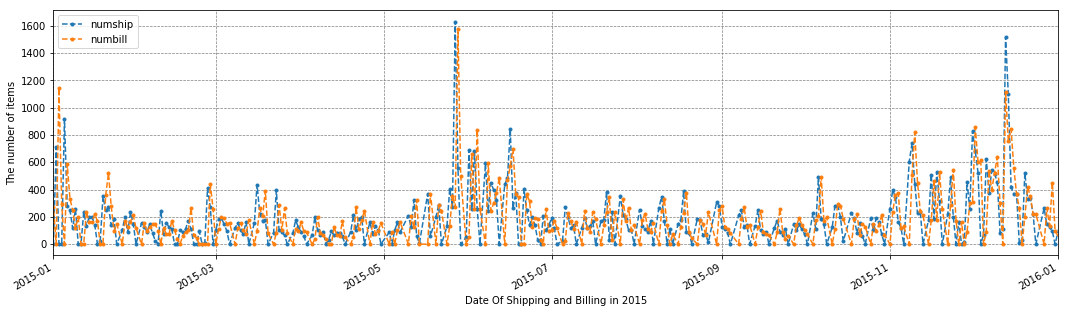

In [6]:
res_all.plot(kind='line',
             style='--.',
             grid=True,
             figsize=(18,5),
             xlim=['2015-01-01','2016-01-01'],
             legend = True)
plt.ylabel('The number of items')
plt.xlabel('Date Of Shipping and Billing in 2015')

plt.grid(linestyle = "--",color = "gray", linewidth = 0.7)

**Analysis: ** This chart is difficult to read because the number of orders shipped and number billed track each other so closely. I find that there is typically a one-day lag between the two, which makes patterns very difficult to see.

In [7]:
def calcMean(s1, s2):
    u1 = s1.mean()
    u2 = s2.mean()
    return u1, u2

def calcPearson(s1, s2):
    u1, u2 = calcMean(s1, s2)
    exy = (s1 - u1) * (s2 - u2)
    xx = (s1 - u1)**2
    yy = (s2 - u2)**2
    r = exy.sum() / (np.sqrt(xx.sum() * yy.sum()))
    return r

In [8]:
pearson_cor = calcPearson(res_all['numship'],res_all['numbill'])
pearson_cor

0.45815648748820903

**Analysis: ** The correlation coefficient (the Pearson correlation) for the two series is 0.4582, which is high, but not that high. 

In [9]:
res_ship_delay1 = res_all['numbill'].shift(-1, freq = 'D')
res_ship_delay1.head()

pearson_cor = calcPearson(res_all['numship'],res_ship_delay1)
pearson_cor

0.8955863753144344

**Analysis: ** the correlation coefficient between numships lagged by one day and numbills is 0.90, which says that the value of ShipDate is ** very highly correlated ** with BillDate minus one.


SQL:
<pre>
SELECT OrderId, COUNT(DISTINCT BillDate) as numbill,
COUNT(DISTINCT ShipDate) as numship
FROM OrderLines
GROUP BY OrderId
</pre>

COUNT(DISTINCT col_num) : Calculate the number of the colum deduplication in the table, Count can not count multiple columns

SQL:
<pre>
SELECT numbill, numship, COUNT(*) as numorders
FROM (SELECT OrderId, COUNT(DISTINCT BillDate) as numbill,
COUNT(DISTINCT ShipDate) as numship
FROM OrderLines
GROUP BY OrderId) o
GROUP BY numbill, numship
ORDER BY numbill, numship
</pre>

In [10]:
# Calculate the number of different bill dates and ship dates for each order(remove duplicated records)
   # notice the Reference type of the parameter and use copy() to avoid
df_order_1 = df_ols[['orderid','shipdate','billdate']].copy() 
df_order_1.loc['shipdate'] = pd.to_datetime(df_order_1['shipdate'])
df_order_1.loc['billdate'] = pd.to_datetime(df_order_1['billdate'])
#df_order_1.info()

# in pandas, nunique() can replace count(distinct col) in SQL，获取特定列中的唯一值
res_1 = df_order_1.groupby(by='orderid')[['shipdate','billdate']] \
                        .nunique().rename(columns={'shipdate':'numship','billdate':'numbill'})
res_1.head()

,numship,numbill
orderid,,
999992,1,1
999993,1,1
999994,1,1
999995,1,1
999996,1,1


In [11]:
# Calculate the Number of Orders Having b Bill Dates and s Ship Dates
res_1['orderid'] = res_1.index
res_2 = res_1.groupby(by=['numbill','numship']).count()
res_2['% of Orders'] = res_2['orderid'] / res_2['orderid'].sum()
res_2

orderid  % of Orders
numbill numship                      
1       1         181637     0.941207
        2              8     0.000041
2       1             35     0.000181
        2          10142     0.052554
        3              1     0.000005
3       2             10     0.000052
        3            999     0.005177
        4              2     0.000010
4       3              3     0.000016
        4            111     0.000575
5       4              1     0.000005
        5             23     0.000119
6       4              1     0.000005
        6              9     0.000047
17      17             1     0.000005

** Analysis： ** The results confirm that almost all orders have a single value for order date and a single value for ship date. This makes sense because most orders have only one order line (and hence only one product). The result also shows that orders with multiple dates typically have the same number of bill dates and ship dates. The policy on billing is that customers only get billed when the items are shipped. The 61 exceptions are probably worth investigating further to determine why this policy is occasionally violated.


In [12]:
df_ods = pd.read_table('data/orders.txt',delimiter='\t',engine='python',dtype={'orderdate':np.datetime64})
df_ods.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192983 entries, 0 to 192982
Data columns (total 11 columns):
orderid          192983 non-null int64
customerid       192983 non-null int64
campaignid       192983 non-null int64
orderdate        192983 non-null datetime64[ns]
city             192964 non-null object
state            191864 non-null object
zipcode          192837 non-null object
paymenttype      192983 non-null object
totalprice       192983 non-null float64
numorderlines    192983 non-null int64
numunits         192983 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(5), object(4)
memory usage: 16.2+ MB


SQL:
<pre>
SELECT EXTRACT(YEAR FROM OrderDate) as year, EXTRACT(MONTH FROM OrderDate) as month,
COUNT(DISTINCT CustomerId) as numcustomers
FROM Orders o
GROUP BY EXTRACT(YEAR FROM OrderDate), EXTRACT(MONTH FROM OrderDate)
ORDER BY year, month
</pre>

In [13]:
# How many customers place orders in each month? 
df_ods_1 = df_ods[['orderdate','customerid']].copy()
#df_ods_1.set_index(df_ods_1['orderdate'],inplace=True)
df_ods_1['order_year'] = df_ods_1['orderdate'].dt.year
df_ods_1['order_month'] = df_ods_1['orderdate'].dt.month
df_ods_1.head()

res_3 = df_ods_1.groupby(by=['order_year','order_month'])['customerid'].nunique()
res_3.name = 'numcustomers'
res_3

order_year  order_month
2009        10             2101
            11             3666
            12             1889
2010        1              1012
            2               249
            3               436
            4               680
            5               439
            6               738
            7               695
            8               971
            9              2292
            10             1330
            11             4235
            12             5319
2011        1              5984
            2              1773
            3              1899
            4              1147
            5              2015
            6              1498
            7              1225
            8              1753
            9              1015
            10             1489
            11             3360
            12             3469
2012        1              2654
            2              2203
            3              1798
                

SQL:
<pre>
SELECT o.OrderId, o.CustomerId, o.OrderDate,
COUNT(DISTINCT ProductId) as prodsperord
FROM Orders o JOIN OrderLines ol ON o.orderid = ol.orderid
GROUP BY o.orderid, o.customerid, o.orderdate
</pre>

SQL:
<pre>
SELECT YEAR(OrderDate) as year, MONTH(OrderDate) as month,
COUNT(*) as numorders, COUNT(DISTINCT CustomerId) as numcusts,
SUM(prodsperord) as sumprodsperorder,
SUM(prodsperord) * 1.0 / COUNT(*) as avgperorder,
SUM(prodsperord) * 1.0 / COUNT(DISTINCT CustomerId) as avgpercust
FROM (SELECT o.OrderId, o.CustomerId, o.OrderDate,
COUNT(DISTINCT ProductId) as prodsperord
FROM Orders o JOIN OrderLines ol ON o.orderid = ol.orderid
GROUP BY o.orderid, o.customerid, o.orderdate ) o
GROUP BY YEAR(OrderDate), MONTH(OrderDate)
ORDER BY year, month
</pre>

In [14]:
# How many “items” as measured by the number of units in each customer’s purchases? 
# Step1: The first is the average number of products per order per customer in days. 
ad_odol = df_ods.merge(df_ols,on='orderid')[['orderid','customerid','orderdate','productid']]
ad_odol.head()

res_4 = ad_odol.groupby(by=['orderid','customerid','orderdate'])['productid'].nunique()
# Extract the composite index of the Series as a column
res_4 = res_4.reset_index()
res_4.head()

#Step2：The second is the average number of products per customer per month. 
res_4['year'] = res_4['orderdate'].dt.year
res_4['month'] = res_4['orderdate'].dt.month
res_4.head()

res_4['orderid'].duplicated().value_counts()
# the column 'customerid' has duplicated values
res_4['customerid'].duplicated().value_counts()

# agg() : after groupby, use different aggregate functions for different columns
res_grouped = res_4.groupby(by=['year','month'])['orderid','customerid','productid'] \
                        .agg({'orderid':'count','customerid':'nunique','productid':'sum'})
res_grouped['avg_per_order'] = res_grouped['productid'] / res_grouped['orderid']
res_grouped['avg_per_cust'] = res_grouped['productid'] / res_grouped['customerid']
res_grouped.rename(columns={'orderid':'numorders','customerid':'numcusts','productid':'sum_prods_grouped'},inplace=True)
res_grouped.head()


numorders  numcusts  sum_prods_grouped  avg_per_order  \
year month                                                          
2009 10          2107      2101               2655       1.260085   
     11          3681      3666               4944       1.343113   
     12          1905      1889               2437       1.279265   
2010 1           1019      1012               1318       1.293425   
     2            253       249                330       1.304348   

            avg_per_cust  
year month                
2009 10         1.263684  
     11         1.348609  
     12         1.290101  
2010 1          1.302372  
     2          1.325301

In [77]:
# 打散
res_grouped_2 = res_grouped.reset_index()
# 拼接
res_grouped_2['year_month'] = res_grouped_2['year'].map(str) + '-' + res_grouped_2['month'].map(str)
# 转时间和index
res_grouped_2['year_month'] = pd.to_datetime(res_grouped_2['year_month'])
res_grouped_2.set_index(res_grouped_2['year_month'],inplace=True)
# res_grouped_2.to_period(copy=False)
res_grouped_2.tail()

,year,month,numorders,numcusts,sum_prods_grouped,avg_per_order,avg_per_cust,year_month
year_month,,,,,,,,
2016-05-01,2016,5,1829,1654,2423,1.324768,1.464933,2016-05-01
2016-06-01,2016,6,2960,2912,3737,1.262500,1.283310,2016-06-01
2016-07-01,2016,7,1698,1664,2734,1.610130,1.643029,2016-07-01
2016-08-01,2016,8,1612,1565,2373,1.472084,1.516294,2016-08-01
2016-09-01,2016,9,460,452,701,1.523913,1.550885,2016-09-01


Text(0,0.5,'Number of Orders')

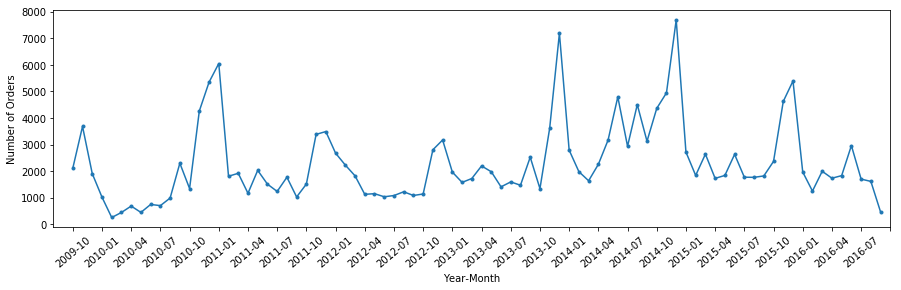

In [110]:
import matplotlib as mpl
import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(15, 4))

# write a custom formatter
records_num = res_grouped_2.shape[0]
# print('records_num',records_num)
idxs = np.arange(records_num)  # the evenly spaced plot indices
date = res_grouped_2['year_month']

# 使用ticker的FuncFormatter，内部会自动调用 自定义的format_fun函数6次（原因未知，但不影响理解）
# tick_value: 刻度值（实数集），对应于整个坐标轴；tick_position：显示的主（副）刻度的编号（0-N）
def format_fun(tick_value, tick_position):
    # 将坐标轴实数刻度 按照要摆放的x轴的 输入集内元素个数，换算成合适的对应index（对应于输入集）
    if tick_value >= 0 and tick_value <= records_num-1:
        return date[int(tick_value)].strftime('%Y-%m') 
    else:
        return ''
    #print('tick_value',tick_value)
    #dateidx = np.clip(int(tick_value + 0.5), 0, records_num - 1)
    #return date[dateidx].strftime('%Y-%m')
    

# 其实 x,y 坐标轴都是按照 实数进行映射位置的
ax.plot(idxs, res_grouped_2['numorders'],'-o',markersize=3)

ax.set_xlim(left=-2, right=records_num)
ax.xaxis.set_major_locator(ticker.MaxNLocator(30))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_fun))
# fig.autofmt_xdate()


# 初始是水平的，逆时针
plt.xticks(rotation=40) 
ax.set_xlabel('Year-Month')
ax.set_ylabel('Number of Orders')

# https://matplotlib.org/2.0.0/api/_as_gen/matplotlib.axes.Axes.set_xticklabels.html
# ax.set_xticklabels(res_grouped_2['year_month'],minor=True,rotation='vertical')

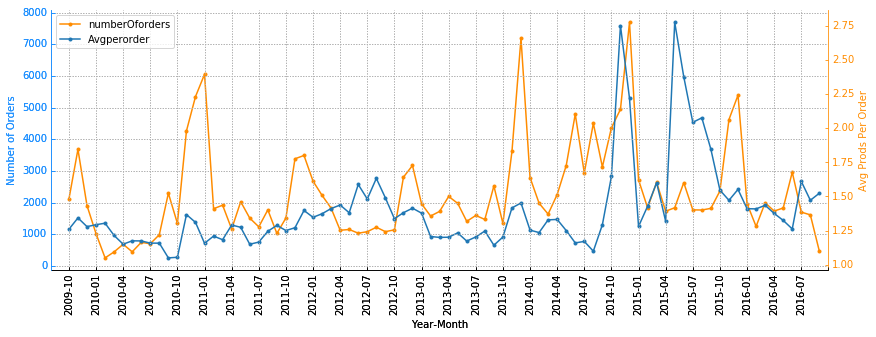

In [152]:
import matplotlib as mpl
import matplotlib.ticker as ticker
from mpl_toolkits.axisartist.parasite_axes import HostAxes, ParasiteAxes


fig = plt.figure(num=1,figsize=(12, 4)) 

# Step1: create parasited host axes-----------------start---------------------
host = HostAxes(fig, [0, 0, 0.9, 0.9])  #用[left, bottom, weight, height]的方式定义axes，0 <= l,b,w,h <= 1

#parasite寄生的 addtional axes, share x
pax_right = ParasiteAxes(host, sharex=host)
#append axes
host.parasites.append(pax_right)


#invisible right axis of ax_cof
host.axis['right'].set_visible(False) #hide主Axes右轴
host.axis['top'].set_visible(False) #hide主Axes 上轴
pax_right.axis['right'].set_visible(True)


#set label for axis
host.set_xlabel('Year-Month')
host.set_ylabel('Number of Orders')

# 将寄生后的主轴添加到figure
fig.add_axes(host)

# Step2: plot host process-----------------start---------------------
def format_fun(tick_value, tick_position):
    if tick_value >= 0 and tick_value <= records_num-1:
        return date[int(tick_value)].strftime('%Y-%m') 
    else:
        return ''

# prepare data
records_num = res_grouped_2.shape[0]
idxs = np.arange(records_num)  # the evenly spaced plot indices
date = res_grouped_2['year_month']

host.plot(idxs, res_grouped_2['numorders'],'-o',markersize=3,label='numberOforders',color='darkorange')

host.set_xlim(left=-2, right=records_num)
host.xaxis.set_major_locator(ticker.MaxNLocator(30))
host.xaxis.set_major_formatter(ticker.FuncFormatter(format_fun))

host.axis['left'].label.set_color('dodgerblue')
host.axis['left'].major_ticklabels.set_color('dodgerblue')
host.axis['left'].major_ticks.set_color('dodgerblue')
host.axis['left'].line.set_color('dodgerblue')

host.axis['bottom'].major_ticklabels.set_axis_direction('left') 

# Step3: plot parasited axes process-----------------start---------------------
pax_right.plot(idxs,res_grouped_2['avg_per_order'],'-o',markersize=3,label='Avgperorder')


pax_right.set_ylabel('Avg Prods Per Order')
pax_right.axis['right'].label.set_visible(True)
pax_right.axis['right'].label.set_color('darkorange')

pax_right.axis['right'].major_ticklabels.set_visible(True)
pax_right.axis['right'].major_ticklabels.set_color('darkorange')
pax_right.axis['right'].major_ticks.set_color('darkorange')
pax_right.axis['right'].line.set_color('darkorange')

# Step4: add another features
host.legend(loc='upper left')

# https://matplotlib.org/api/_as_gen/matplotlib.pyplot.grid.html
host.grid(linestyle=':', linewidth=1)

** Analysis: **The average products per order and per customer are pretty much the same on a monthly basis. The figure shows the results of the query, with the number of customers plotted on the left axis and the average products per order plotted on the right. This chart shows peaks in the average products in an order. Most months have a bit over one product per order, but November 2014 and May 2015 peak at twice that value.

In [16]:
from bokeh.io import output_notebook
output_notebook()

from bokeh.plotting import figure,show
from bokeh.models import ColumnDataSource

Loading BokehJS ...

In [18]:
source = ColumnDataSource(data = pd.DataFrame(res_grouped_2['numorders']))

def datetime(x):
    return np.array(x, dtype=np.datetime64)

p = figure(plot_width=600, plot_height=400)
p.line(x=datetime(res_grouped_2['year_month']),y=res_grouped_2['numorders'],
       line_width=1, line_alpha = 0.8, line_color = 'black',line_dash = [10,4]) 

show(p)

In [21]:
# How does an average customer’s monthly order size change over time? 

# How many distinct products, as measured by distinct product IDs in each customer’s order? 